In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from scipy import stats
from sklearn.model_selection import train_test_split

In [3]:
# get a list of all folders
filepath = "SensorLogger/"
dir_list = os.listdir(filepath)
end = len(dir_list)
dir_list = dir_list[end-3:end]
dir_list

['2022-11-16_20-24-32', '2022-11-14_14-07-05', '2022-11-15_19-43-07']

# Preprocessing Data

In [4]:
#read in microphone data
sound = {}
samplerate = {}
for i,d in enumerate([1,2,0]):
    mic_path = filepath + dir_list[d] + "/Microphone.wav"
    samplerate[i], sound[i] = wavfile.read(mic_path)


In [5]:
"""
time = {}
for i in np.arange(3):
    min_time = np.min(day[i]['t0'])
    max_time = np.max(day[i]['t0'])
    length = len(data[i])
    t = np.linspace(min_time, max_time, length)
    time[i] = t
"""

"\ntime = {}\nfor i in np.arange(3):\n    min_time = np.min(day[i]['t0'])\n    max_time = np.max(day[i]['t0'])\n    length = len(data[i])\n    t = np.linspace(min_time, max_time, length)\n    time[i] = t\n"

In [6]:
#read in motion data
motion = {}
for i,n in enumerate([1,2,0]):
    path_acce = filepath + dir_list[n] + "/"+ "Accelerometer.csv"
    path_gyro = filepath + dir_list[n] + "/"+"Gyroscope.csv"

    df1 = pd.read_csv(path_acce)
    df2 = pd.read_csv(path_gyro)

    df1.rename(columns={"x": "Accel_x", "y": "Accel_y","z":"Accel_z"}, inplace=True)
    df2.rename(columns={"x": "Gyros_x", "y": "Gyros_y","z":"Gyros_z"}, inplace=True)
    df1 = df1[['time', 'seconds_elapsed', 'Accel_x','Accel_y','Accel_z']]
    df2 = df2[['time', 'seconds_elapsed', 'Gyros_x','Gyros_y','Gyros_z']]

    df = pd.merge(df1, df2, on=["time","seconds_elapsed"])
    df = df.drop(["time"], axis=1)  
    df.rename(columns={"seconds_elapsed": "t0"}, inplace=True)

    motion[i] = df

In [7]:
#load bike labels
labels = pd.read_csv("BikeLabels2.csv")
label = {}
label[0] = labels[labels["video"]=="11-14-22"]
label[1] = labels[labels["video"]=="11-15-22"]
label[2] = labels[labels["video"]=="11-16-22"]

In [8]:
# load time shifting
shifting = pd.read_csv("time_shift.csv")
shift = {}
shift[0] = shifting[shifting["video"]=="11-14-22"]
shift[1] = shifting[shifting["video"]=="11-15-22"]
shift[2] = shifting[shifting["video"]=="11-16-22"]

In [9]:
label[0].loc[:,"s_video_start"]

0      681
1     1315
2     1407
3     1754
4     2207
5     2464
6     4183
7     4485
8     4839
9     5059
10    7299
11    8239
12    9806
Name: s_video_start, dtype: int64

In [10]:
#apply time shift

for i in np.arange(len(label)):
    label[i]["s_video_start"] = label[i]["s_video_start"] + shift[i].at[i, "s_to_senser_from_v"]
    label[i]["s_video_end"] = label[i]["s_video_end"] + shift[i].at[i, "s_to_senser_from_v"]

/var/folders/l4/7p0l2bnj1nggqtd_8rmt2g3c0000gn/T/ipykernel_3255/2370414527.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label[i]["s_video_start"] = label[i]["s_video_start"] + shift[i].at[i, "s_to_senser_from_v"]
/var/folders/l4/7p0l2bnj1nggqtd_8rmt2g3c0000gn/T/ipykernel_3255/2370414527.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label[i]["s_video_end"] = label[i]["s_video_end"] + shift[i].at[i, "s_to_senser_from_v"]


In [11]:
label

{0:        video  s_video_start   s_video_end In/Out  Rack
 0   11-14-22    1292.930006   1331.930006     In     0
 1   11-14-22    1926.930006   1956.930006     In     0
 2   11-14-22    2018.930006   2062.930006     In     1
 3   11-14-22    2365.930006   2388.930006     In     0
 4   11-14-22    2818.930006   2880.930006     In     1
 5   11-14-22    3075.930006   3174.930006     In     1
 6   11-14-22    4794.930006   4812.930006     In     1
 7   11-14-22    5096.930006   5158.930006     In     1
 8   11-14-22    5450.930006   5475.930006     In     0
 9   11-14-22    5670.930006   5754.930006     In     1
 10  11-14-22    7910.930006   7974.930006     In     0
 11  11-14-22    8850.930007   8891.930007    Out     1
 12  11-14-22   10417.930007  10442.930007     In     1,
 1:        video  s_video_start  s_video_end In/Out  Rack
 13  11-15-22    1738.064006  1858.064006    Out     0,
 2:        video  s_video_start  s_video_end In/Out  Rack
 14  11-16-22    4026.164001  4102.16400

In [12]:
def upsample(sound, motion):
    temp_motion = motion
    temp_motion.set_index('t0',inplace =True)
    length = len(sound)
    t_min = np.min(temp_motion.index)
    t_max = np.max(temp_motion.index)
    new_ts = np.linspace(t_min, t_max, length)
    resampled_motion = temp_motion.reindex(temp_motion.index.union(new_ts)).interpolate('values').loc[new_ts]
    return resampled_motion

In [13]:
#upsample motion data to match dimensions of audio data###
resample_motion = {}
for i in np.arange(len(motion)):
    resample_motion[i] = upsample(sound[i], motion[i])
motion = resample_motion

In [14]:
for i in np.arange(len(motion)):
    motion[i].reset_index(inplace=True)
    motion[i] = motion[i].to_numpy()
    label[i] = label[i].to_numpy()

In [17]:
motion[0].shape

(94366080, 7)

In [18]:
motion[0][0:1000,:7].shape

(1000, 7)

In [12]:
label[0], label[1], label[2]

(array([['11-14-22', 1292.9300065, 1331.9300065, 'In', 0],
        ['11-14-22', 1926.9300065, 1956.9300065, 'In', 0],
        ['11-14-22', 2018.9300065, 2062.9300064999998, 'In', 1],
        ['11-14-22', 2365.9300064999998, 2388.9300064999998, 'In', 0],
        ['11-14-22', 2818.9300064999998, 2880.9300064999998, 'In', 1],
        ['11-14-22', 3075.9300064999998, 3174.9300064999998, 'In', 1],
        ['11-14-22', 4794.9300065, 4812.9300065, 'In', 1],
        ['11-14-22', 5096.9300065, 5158.9300065, 'In', 1],
        ['11-14-22', 5450.9300065, 5475.9300065, 'In', 0],
        ['11-14-22', 5670.9300065, 5754.9300065, 'In', 1],
        ['11-14-22', 7910.9300065, 7974.9300065, 'In', 0],
        ['11-14-22', 8850.9300065, 8891.9300065, 'Out', 1],
        ['11-14-22', 10417.9300065, 10442.9300065, 'In', 1]], dtype=object),
 array([['11-15-22', 1738.0640061, 1858.0640061, 'Out', 0]], dtype=object),
 array([['11-16-22', 4026.1640007, 4102.1640007, 'Out', 0],
        ['11-16-22', 4076.1640007, 4

In [19]:
#add labels, set to 0
for i in np.arange(len(motion)):
    zeros = np.zeros([len(motion[i]),1])
    motion[i] = np.hstack([motion[i], zeros])

In [28]:
motion[0][0:1000,7];

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [15]:
for d in np.arange(len(label)):
    print(d)
    start = label[d][:,1] #start timestamp
    end = label[d][:,2] #end timestamp
    event = label[d][:,3] #in or out
    time = motion[d][:,0] #timestamps from motion
    for i in np.arange(label[d].shape[0]):
        if event[i] == "In":
            motion[d][:,7] = motion[d][:,7] + ((start[i] <= time) & (end[i] >= time))
        else:
            #print(motion[d][:,7].shape)
            #print([(start[0] <= time) & (end[0] >= time)].shape)
            motion[d][:,7] = motion[d][:,7] + -1*((start[i] <= time) & (end[i] >= time))

0
1
2


In [16]:
np.unique(motion[2][:,7], return_counts=True)

(array([-2., -1.,  0.,  1.]), array([  208106,  2801432, 58664473,   448229]))

In [68]:
print(np.unique(motion[0][:,7], return_counts=True))
print(np.unique(motion[1][:,7], return_counts=True))
print(np.unique(motion[2][:,7], return_counts=True))

(array([-1.,  0.,  1.]), array([  328136, 89436044,  4601900]))
(array([-1.,  0.]), array([  960167, 32831033]))
(array([-2., -1.,  0.,  1.]), array([  208106,  2801432, 58664473,   448229]))


In [136]:
# labeling function
def labeling(labels):
    if not labels.any():
        return 0
    else:
        non_zero = labels[labels!=0]
        return stats.mode(non_zero, keepdims=True)[0][0]

In [132]:
b = a[a!=0]

In [135]:
labeling(b)

1.0

In [118]:
a = np.zeros(20)
a[1] = 1
a[2] = 1
a[4] = -1
a = [int(a)]

TypeError: only size-1 arrays can be converted to Python scalars

In [87]:
#sample data into bins where each example is (1000 x #features)
step_rate = 10
window_size = 80000

In [111]:
len(motion[0]) - (len(motion[0])//80000*80000 - 80000*(1-1/4))

106080.0

In [137]:
#11-14-22

bins_1 = []
labels_1 = []
m1 = motion[0]
print("start")
for i in np.arange(0, len(motion[0])//window_size * window_size - window_size * (1-1/step_rate), window_size/step_rate):
  if i%5000000==0:
    print(i)
  i = int(i)

  feats = m1[i:i+window_size,:7]

  labels_subset = m1[i:i+window_size,7]
  #vals, counts = np.unique(labels_subset, return_counts=True)
  label = labeling(labels_subset)
  labels_1 = np.append(labels_1, label)

  bins_1 = np.append(bins_1, feats)
  #bins_1.append([x_acc, y_acc, z_acc, x_gyro, y_gyro, z_gyro])

#bins_1 = bins_1.to_numpy()
#bins_1 = bins_1.transpose(0,2,1)

start
0.0
5000000.0


KeyboardInterrupt: 

In [ ]:
"""
#11-14-22

bins_1 = []
labels_1 = []

for i in np.arange(0, len(motion[0])//window_size * window_size - window_size/2, window_size/step_rate):
  #print(i)
  x_acc = motion[0]['Accel_x'].values[int(i):int(i+window_size)]
  y_acc = motion[0]['Accel_y'].values[int(i):int(i+window_size)]
  z_acc = motion[0]['Accel_z'].values[int(i):int(i+window_size)]
  x_gyro = motion[0]['Gyros_x'].values[int(i):int(i+window_size)]
  y_gyro = motion[0]['Gyros_y'].values[int(i):int(i+window_size)]
  z_gyro = motion[0]['Gyros_z'].values[int(i):int(i+window_size)]
  #audio = sound[0][int(i):int(i+window_size)]

  labels_subset = motion[0]["label"].to_numpy()[int(i):int(i+window_size)]
  vals, counts = np.unique(labels_subset, return_counts=True)
  label = labeling(vals, counts)
  labels_1.append(label)

  bins_1.append([x_acc, y_acc, z_acc, x_gyro, y_gyro, z_gyro])

bins_1 = np.array(bins_1)
bins_1 = bins_1.transpose(0,2,1)
"""

0.0
8000.0
16000.0
24000.0
32000.0
40000.0
48000.0
56000.0
64000.0
72000.0
80000.0
88000.0
96000.0
104000.0
112000.0
120000.0
128000.0
136000.0
144000.0
152000.0
160000.0
168000.0
176000.0
184000.0
192000.0
200000.0
208000.0
216000.0
224000.0
232000.0
240000.0
248000.0
256000.0
264000.0
272000.0
280000.0
288000.0
296000.0
304000.0
312000.0
320000.0
328000.0
336000.0
344000.0
352000.0
360000.0
368000.0
376000.0
384000.0
392000.0
400000.0
408000.0
416000.0
424000.0
432000.0
440000.0
448000.0
456000.0
464000.0
472000.0
480000.0
488000.0
496000.0
504000.0
512000.0
520000.0
528000.0
536000.0
544000.0
552000.0
560000.0
568000.0
576000.0
584000.0
592000.0
600000.0
608000.0
616000.0
624000.0
632000.0
640000.0
648000.0
656000.0
664000.0
672000.0
680000.0
688000.0
696000.0
704000.0
712000.0
720000.0
728000.0
736000.0
744000.0
752000.0
760000.0
768000.0
776000.0
784000.0
792000.0
800000.0
808000.0
816000.0
824000.0
832000.0
840000.0
848000.0
856000.0
864000.0
872000.0
880000.0
888000.0
896000.0
9

: 

: 

In [ ]:
#11-15-22

bins_2 = []
labels_2 = []
m2 = motion[1]
print("start")

for i in np.arange(0, len(motion[1])//window_size * window_size - window_size/2, window_size/step_rate):

  if i%5000000==0:
    print(i)
  i = int(i)

  feats = m2[i:i+window_size,:7]

  labels_subset = m2[i:i+window_size,7]
  #vals, counts = np.unique(labels_subset, return_counts=True)
  label = labeling(labels_subset)
  labels_1 = np.append(labels_1, label)

  bins_1 = np.append(bins_1, feats)
  """
  x_acc = motion[1]['Accel_x'].values[int(i):int(i+window_size)]
  y_acc = motion[1]['Accel_y'].values[int(i):int(i+window_size)]
  z_acc = motion[1]['Accel_z'].values[int(i):int(i+window_size)]
  x_gyro = motion[1]['Gyros_x'].values[int(i):int(i+window_size)]
  y_gyro = motion[1]['Gyros_y'].values[int(i):int(i+window_size)]
  z_gyro = motion[1]['Gyros_z'].values[int(i):int(i+window_size)]
  audio = sound[0][int(i):int(i+window_size)]

  labels_subset = motion[1]["label"].iloc[int(i):int(i+window_size)]
  vals, counts = np.unique(labels_subset, return_counts=True)
  label = labeling(vals, counts)
  labels_2.append(label)

  bins_2.append([x_acc, y_acc, z_acc, x_gyro, y_gyro, z_gyro, audio])

  """

bins_2 = np.array(bins_2)
bins_2 = bins_2.transpose(0,2,1)

In [ ]:
#11-16-22

bins_3 = []
labels_3 = []
m3 = motion[1]
print("start")

for i in np.arange(0, len(motion[2])//window_size * window_size - window_size/2, window_size/step_rate):
  
  if i%5000000==0:
    print(i)
  i = int(i)

  feats = m3[i:i+window_size,:7]

  labels_subset = m3[i:i+window_size,7]
  #vals, counts = np.unique(labels_subset, return_counts=True)
  label = labeling(labels_subset)
  labels_1 = np.append(labels_1, label)

  bins_1 = np.append(bins_1, feats)
  """
  x_acc = motion[2]['Accel_x'].values[int(i):int(i+window_size)]
  y_acc = motion[2]['Accel_y'].values[int(i):int(i+window_size)]
  z_acc = motion[2]['Accel_z'].values[int(i):int(i+window_size)]
  x_gyro = motion[2]['Gyros_x'].values[int(i):int(i+window_size)]
  y_gyro = motion[2]['Gyros_y'].values[int(i):int(i+window_size)]
  z_gyro = motion[2]['Gyros_z'].values[int(i):int(i+window_size)]
  sound = sound[0][int(i):int(i+window_size)]

  labels_subset = motion[2]["label"].iloc[int(i):int(i+window_size)]
  vals, counts = np.unique(labels_subset, return_counts=True)
  label = labeling(vals, counts)
  labels_3.append(label)

  bins_3.append([x_acc, y_acc, z_acc, x_gyro, y_gyro, z_gyro, sound])
  """
bins_3 = np.array(bins_3)
bins_3 = bins_3.transpose(0,2,1)

In [ ]:
examples = {0:bins_1, 1:bins_2, 2: bins_3}
labels = {0:labels_1, 1:labels_2, 2: labels_3}

In [ ]:
examples[0].shape, examples[1].shape, examples[2].shape

((11725, 1000, 6), (4205, 1000, 6), (7745, 1000, 6))

In [ ]:
len(labels[0]), len(labels[1]), len(labels[2])

(11725, 4205, 7745)

In [ ]:
#concatenate into single tensor

X = np.vstack((examples[0], examples[1], examples[2]))
y = np.hstack((labels[0], labels[1], labels[2]))

In [ ]:
X.shape

(23675, 1000, 6)

In [ ]:
#normalize data

X[:,:,0] = X[:,:,0]/np.max(np.abs(X[:,:,0])) #motion (0-5)
X[:,:,1] = X[:,:,1]/np.max(np.abs(X[:,:,1]))
X[:,:,2] = X[:,:,2]/np.max(np.abs(X[:,:,2]))
X[:,:,3] = X[:,:,3]/np.max(np.abs(X[:,:,3]))
X[:,:,4] = X[:,:,4]/np.max(np.abs(X[:,:,4]))
X[:,:,5] = X[:,:,5]/np.max(np.abs(X[:,:,5])) 
X[:,:,6] = X[:,:,5]/np.max(np.abs(X[:,:,5])) #audio

In [ ]:
#split into test/train sets
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size = 0.3, random_state = 123)

In [ ]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([-2, -1,  0,  1]), array([   10,   137, 16196,   229])),
 (array([-1,  0,  1]), array([  52, 6949,  102])))

In [ ]:
#next 
#concat examples into single example 3D array
#normalize values by feature

#next work on microphone data

# Preprocessing Microphone Data

In [ ]:
#read in microphone data

samplerate = {}
data = {}
for i,d in enumerate([1,2,0]):
    mic_path = filepath + dir_list[d] + "/Microphone.wav"
    samplerate[i], data[i] = wavfile.read(mic_path)


In [ ]:
len(data[0]), len(data[1]), len(data[2])

(94366080, 33791200, 62122240)

In [ ]:
time = {}
for i in np.arange(3):
    min_time = np.min(day[i]['t0'])
    max_time = np.max(day[i]['t0'])
    length = len(data[i])
    t = np.linspace(min_time, max_time, length)
    time[i] = t


In [ ]:
#apply time shift


       X    Y1     Y2
0   1.10  10.1  55.05
1   2.05  15.2  40.40
2   3.07  35.3  84.17
3   4.20  40.4  31.50
4   5.00  44.3  55.00
5   7.00  46.1  65.00
6   9.00  49.1  43.00
7  10.50  55.6  33.00
         Y1     Y2
X                 
1.10   10.1  55.05
2.05   15.2  40.40
3.07   35.3  84.17
4.20   40.4  31.50
5.00   44.3  55.00
7.00   46.1  65.00
9.00   49.1  43.00
10.50  55.6  33.00
[1.   2.75 4.5  6.25 8.  ]
             Y1         Y2
X                         
1.00        NaN        NaN
2.75  28.994118  70.438235
4.50  41.862500  40.312500
6.25  45.425000  61.250000
8.00  47.600000  54.000000


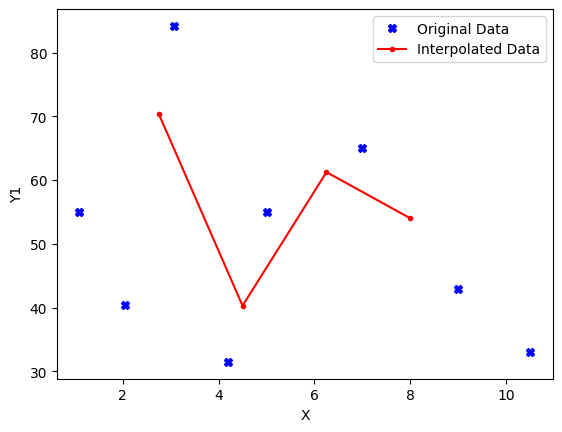

In [ ]:
df = pd.DataFrame({'X' : [1.1, 2.05, 3.07, 4.2,5,7,9,10.5],
		   'Y1': [10.1, 15.2, 35.3, 40.4,44.3, 46.1, 49.1, 55.6],
		   'Y2': [55.05, 40.4, 84.17, 31.5, 55, 65, 43, 33]})
print(df)

df.set_index('X',inplace =True)
print(df)

Xresampled = np.linspace(1,8,5)
print(Xresampled)

#Resampling
#df = df.reindex(df.index.union(resampling))

#Interpolation technique to use. One of:

#'linear': Ignore the index and treat the values as equally spaced. This is the only method supported on MultiIndexes.
#'time': Works on daily and higher resolution data to interpolate given length of interval.
#'index', 'values': use the actual numerical values of the index.
#'pad': Fill in NaNs using existing values.
#'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline', 'barycentric', 'polynomial': Passed to scipy.interpolate.interp1d. These methods use the numerical values of the index. Both 'polynomial' and 'spline' require that you also specify an order (int), e.g. df.interpolate(method='polynomial', order=5).
#'krogh', 'piecewise_polynomial', 'spline', 'pchip', 'akima': Wrappers around the SciPy interpolation methods of similar names. See Notes.
#'from_derivatives': Refers to scipy.interpolate.BPoly.from_derivatives which replaces 'piecewise_polynomial' interpolation method in scipy 0.18.
	
df_resampled = df.reindex(df.index.union(Xresampled)).interpolate('values').loc[Xresampled]
print(df_resampled)

# gca stands for 'get current axis'
ax = plt.gca()
df.plot(           style='X',  y='Y2', color = 'blue', ax=ax, label = 'Original Data'     )
df_resampled.plot( style='.-', y='Y2', color = 'red',  ax=ax, label = 'Interpolated Data' )
ax.set_ylabel('Y1')
plt.show()

In [ ]:
int(len(data[0])/len(day[0]["t0"]))

80

In [ ]:
len(time[0]), len(data[0]), len(day[0]["t0"])

(94366080, 94366080, 1173652)

In [ ]:
len(time[0]), len(time[1]), len(time[2])

(94366080, 33791200, 62122240)

In [ ]:
len(time[0]) == len(data[0]), len(time[1]) == len(data[1]), len(time[1]) == len(data[1])

(True, True, True)

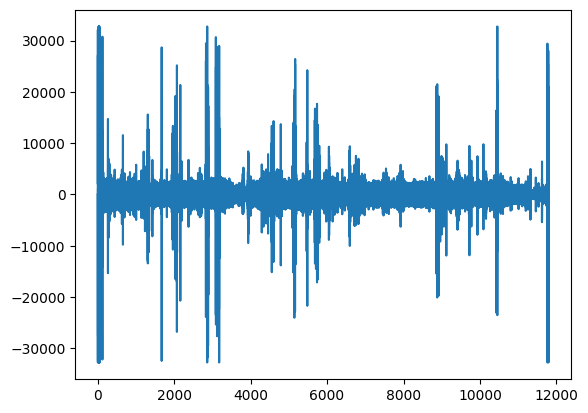

In [ ]:
plt.plot(time, data[0])

ValueError: x and y must have same first dimension, but have shapes (94366080,) and (1173652, 8)

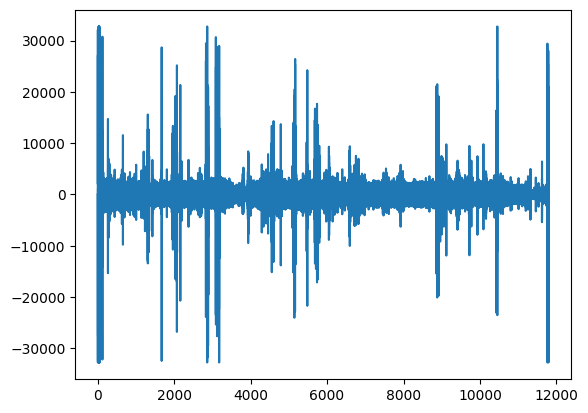

In [ ]:
plt.plot(time[0], data[0])
#plt.plot(time[0], day[0])

In [ ]:
len(day[0]["t0"])

1173652

In [ ]:
time[0].shape

(94366080,)